In [2]:
import torchvision.transforms.functional as TF
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
    
print("Import Completed")

import sys
sys.path.append("..")
# from latexify import latexify, format_axes

!wget https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg -O iitgn.jpg
# Set the random seed for reproducibility
torch.manual_seed(42)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")



Device:  cuda
Import Completed
--2024-09-16 20:31:23--  https://news.iitgn.ac.in/wp/wp-content/uploads/2024/06/IITGN-campus-3-2.jpeg
Resolving news.iitgn.ac.in (news.iitgn.ac.in)... 192.185.129.4
Connecting to news.iitgn.ac.in (news.iitgn.ac.in)|192.185.129.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238762 (233K) [image/jpeg]
Saving to: 'iitgn.jpg'

iitgn.jpg           100%[===================>] 233.17K  1.28MB/s    in 0.2s    

2024-09-16 20:31:23 (1.28 MB/s) - 'iitgn.jpg' saved [238762/238762]

Using 2 GPUs


torch.Size([3, 600, 900])


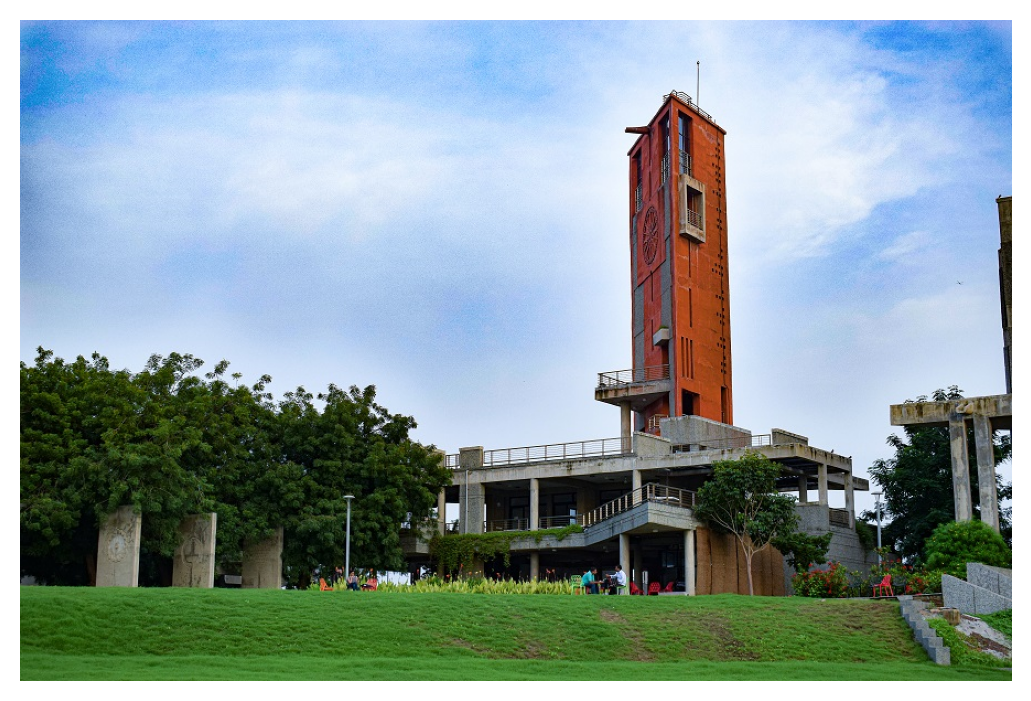

In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("iitgn.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
plt.axis('off')
plt.show()

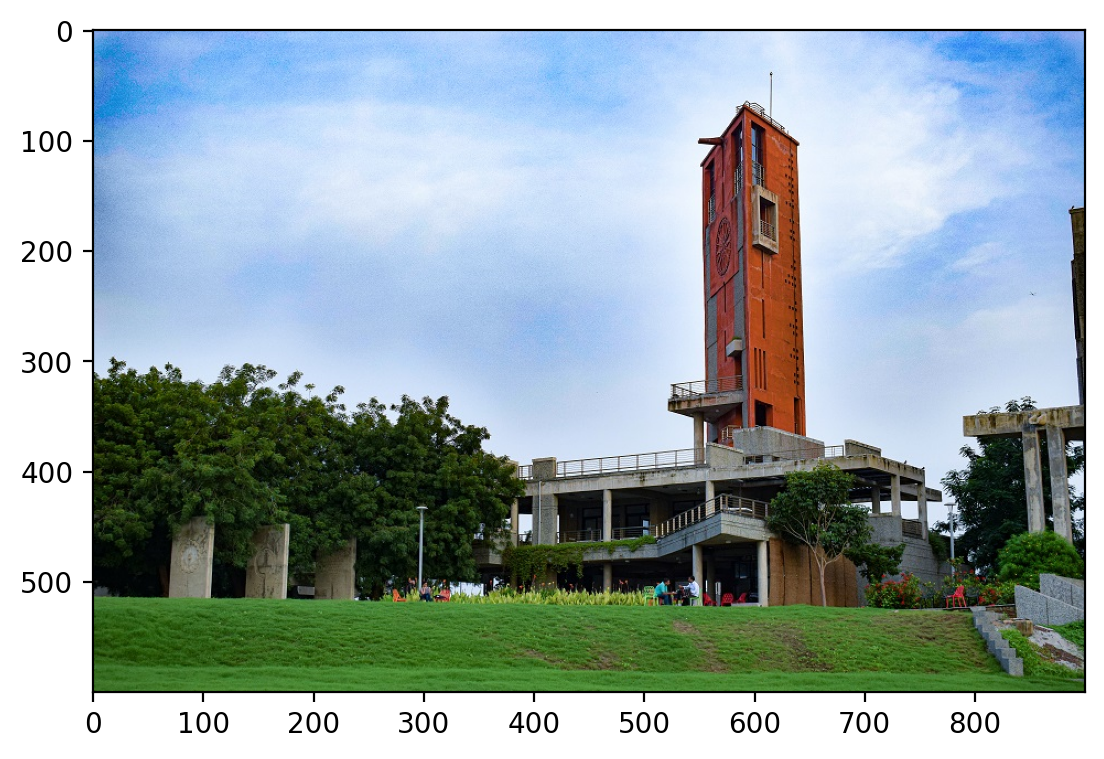

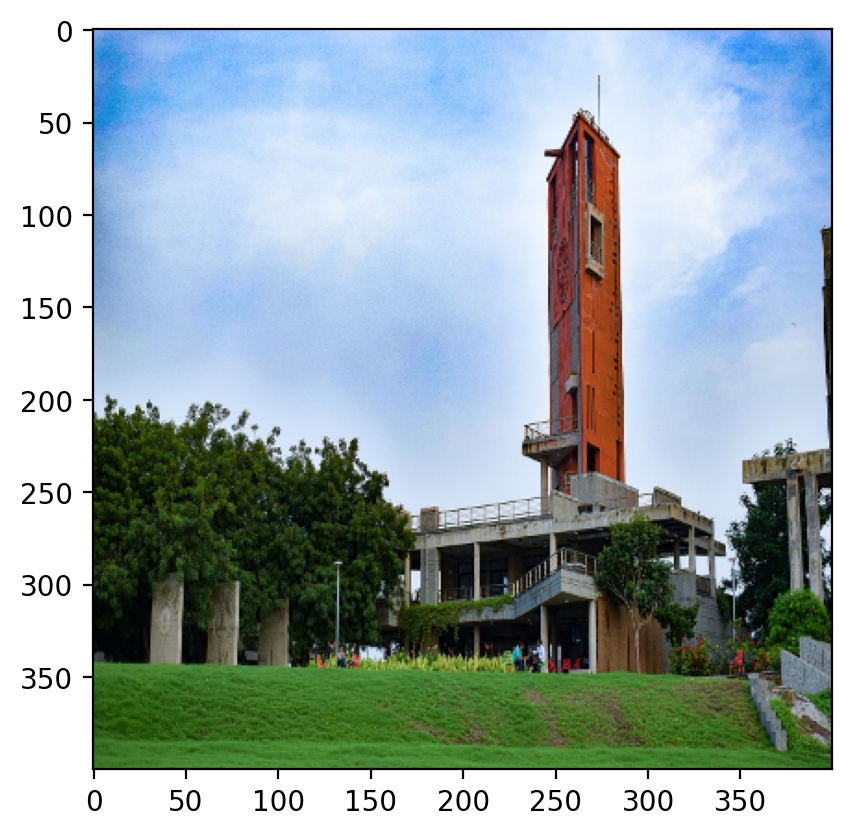

In [4]:
import cv2
# Load the original high-resolution image (400x400)
image = cv2.imread('iitgn.jpg')  # Update the path accordingly
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
image_hr = cv2.resize(image, (400, 400))
plt.imshow(image_hr)
plt.show()

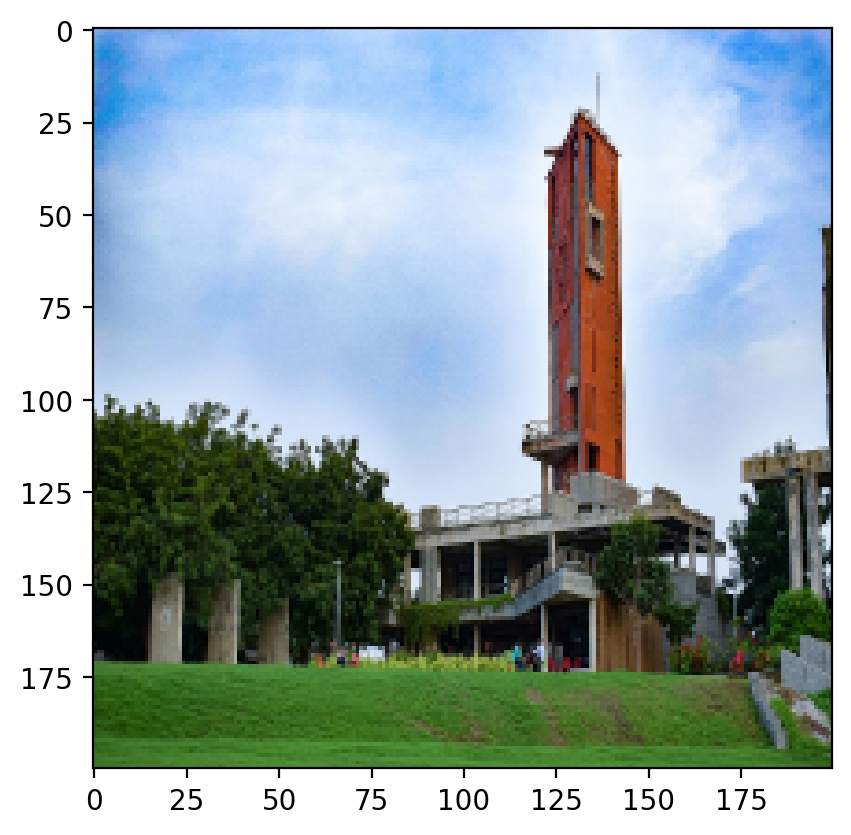

Features created
Channel: 0
Channel: 1
Channel: 2
Training Completed


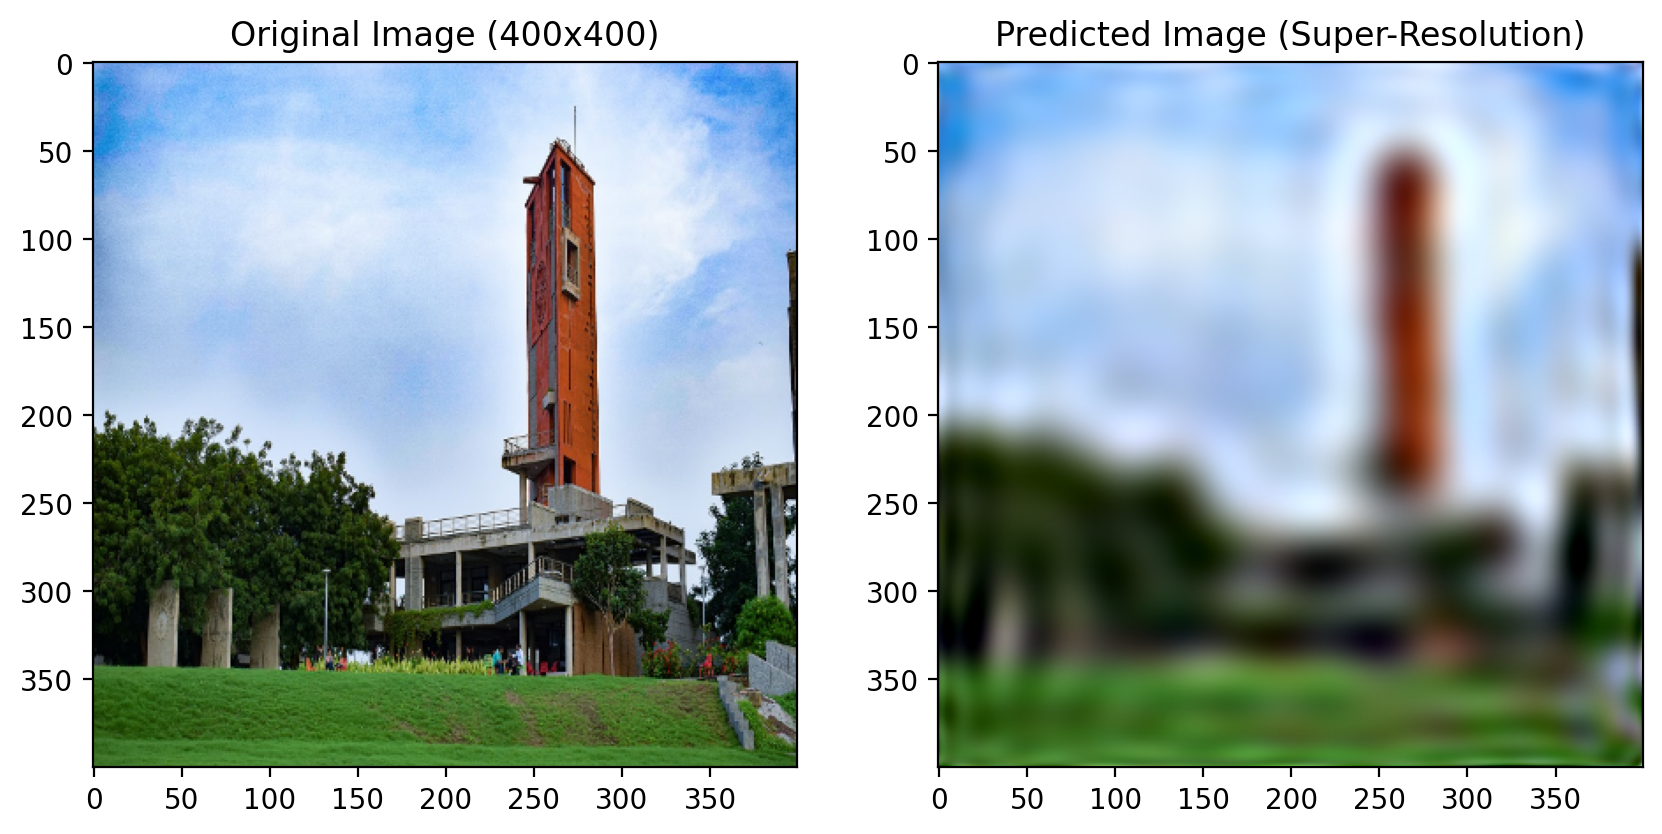

RMSE: 8.093957108032305
PSNR: 19.437897170464804


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.kernel_approximation import RBFSampler

# Downsample the image to 200x200
image_lr = cv2.resize(image_hr, (200, 200))
plt.imshow(image_lr)
plt.show()

# Normalize the images
image_hr_normalized = image_hr / 255.0
image_lr_normalized = image_lr / 255.0

# Prepare the data: Generate coordinates for each pixel in the 200x200 image
coords_lr = np.array([[i, j] for i in range(200) for j in range(200)])

# Apply Random Fourier Features to the coordinates
rff = RBFSampler(gamma=0.001, n_components=5000, random_state=42)  # Adjust gamma and components as needed
features_lr = rff.fit_transform(coords_lr)

print("Features created");
# Train a linear regression model to learn the pixel mapping for each color channel
predicted_hr = np.zeros((400, 400, 3))

for channel in range(3):  # For each color channel: Red, Green, Blue
    print("Channel:",channel)
    # Flatten the image into a 1D array
    pixels_lr = image_lr_normalized[:, :, channel].flatten()
    
    # Train the linear regression model
    model = LinearRegression()
    model.fit(features_lr, pixels_lr)
    
    # Generate new coordinates for the 400x400 grid (including in-between pixels)
    coords_hr = np.array([[i / 2, j / 2] for i in range(400) for j in range(400)])
    
    # Transform these new coordinates using the same RFF
    features_hr = rff.transform(coords_hr)
    
    # Predict the pixel values at the new (higher-resolution) coordinates
    predicted_pixels_hr = model.predict(features_hr)
    
    # Reshape the predicted pixels to the 400x400 image dimensions
    predicted_hr[:, :, channel] = predicted_pixels_hr.reshape(400, 400)

print("Training Completed");
# Denormalize the predicted image
predicted_hr = np.clip(predicted_hr * 255.0, 0, 255).astype(np.uint8)

# Calculate RMSE and PSNR
rmse_value = np.sqrt(mean_squared_error(image_hr.flatten(), predicted_hr.flatten()))
psnr_value = psnr(image_hr, predicted_hr)

# Display the original and predicted images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_hr)
plt.title("Original Image (400x400)")
plt.subplot(1, 2, 2)
plt.imshow(predicted_hr)
plt.title("Predicted Image (Super-Resolution)")

plt.show()

print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.kernel_approximation import RBFSampler

# Downsample the image to 200x200
image_lr = cv2.resize(image_hr, (200, 200))
plt.imshow(image_lr)
plt.show()

# Normalize the images
image_hr_normalized = image_hr / 255.0
image_lr_normalized = image_lr / 255.0

# Prepare the data: Generate coordinates for each pixel in the 200x200 image
coords_lr = np.array([[i, j] for i in range(200) for j in range(200)])

# Apply Random Fourier Features to the coordinates
rff = RBFSampler(gamma=0.001, n_components=20000, random_state=42)  # Adjust gamma and components as needed
features_lr = rff.fit_transform(coords_lr)

print("Features created");
# Train a linear regression model to learn the pixel mapping for each color channel
predicted_hr = np.zeros((400, 400, 3))

for channel in range(3):  # For each color channel: Red, Green, Blue
    print("Channel:",channel)
    # Flatten the image into a 1D array
    pixels_lr = image_lr_normalized[:, :, channel].flatten()
    
    # Train the linear regression model
    model = LinearRegression()
    model.fit(features_lr, pixels_lr)
    
    # Generate new coordinates for the 400x400 grid (including in-between pixels)
    coords_hr = np.array([[i / 2, j / 2] for i in range(400) for j in range(400)])
    
    # Transform these new coordinates using the same RFF
    features_hr = rff.transform(coords_hr)
    
    # Predict the pixel values at the new (higher-resolution) coordinates
    predicted_pixels_hr = model.predict(features_hr)
    
    # Reshape the predicted pixels to the 400x400 image dimensions
    predicted_hr[:, :, channel] = predicted_pixels_hr.reshape(400, 400)

print("Training Completed");
# Denormalize the predicted image
predicted_hr = np.clip(predicted_hr * 255.0, 0, 255).astype(np.uint8)

# Calculate RMSE and PSNR
rmse_value = np.sqrt(mean_squared_error(image_hr.flatten(), predicted_hr.flatten()))
psnr_value = psnr(image_hr, predicted_hr)

# Display the original and predicted images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_hr)
plt.title("Original Image (400x400)")
plt.subplot(1, 2, 2)
plt.imshow(predicted_hr)
plt.title("Predicted Image (Super-Resolution)")

plt.show()

print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")
